## A simple Multi-Agent RL notebook.
The green agent is trying to swipe the entire grid, while the blue agent is trying to stop the green agent from doing it.

![fdfd](ezgif.com-gif-maker.gif)

In [ ]:
# Let's code our multi-agent environment.

import gym
from gym.spaces import Discrete, MultiDiscrete
import numpy as np
import random
import matplotlib.pyplot as plt
import pygame

from ray.rllib.env.multi_agent_env import MultiAgentEnv


class MultiAgentArena(MultiAgentEnv):
    def __init__(self, config=None):
        config = config or {}
        # Dimensions of the grid.
        self.width = config.get("width", 10)
        self.height = config.get("height", 10)

        # End an episode after this many timesteps.
        self.timestep_limit = config.get("ts", 100)

        self.observation_space = MultiDiscrete([self.width * self.height,
                                                self.width * self.height])
        # 0=up, 1=right, 2=down, 3=left.
        self.action_space = Discrete(4)

        # Reset env.
        self.reset()
        
    def reset(self):
        """Returns initial observation of next(!) episode."""
        # Row-major coords.
        self.agent1_pos = [0, 0]  # upper left corner
        self.agent2_pos = [self.height - 1, self.width - 1]  # lower bottom corner

        # Accumulated rewards in this episode.
        self.agent1_R = 0.0
        self.agent2_R = 0.0

        # Reset agent1's visited fields.
        self.agent1_visited_fields = set([tuple(self.agent1_pos)])

        # How many timesteps have we done in this episode.
        self.timesteps = 0

        # Return the initial observation in the new episode.
        return self._get_obs()

    def step(self, action: dict):
        """
        Returns (next observation, rewards, dones, infos) after having taken the given actions.
        
        e.g.
        `action={"agent1": action_for_agent1, "agent2": action_for_agent2}`
        """
        
        # increase our time steps counter by 1.
        self.timesteps += 1
        # An episode is "done" when we reach the time step limit.
        is_done = self.timesteps >= self.timestep_limit

        # Agent2 always moves first.
        # events = [collision|agent1_new_field]
        events = self._move(self.agent2_pos, action["agent2"], is_agent1=False)
        events |= self._move(self.agent1_pos, action["agent1"], is_agent1=True)

        # Useful for rendering.
        self.collision = "collision" in events
            
        # Get observations (based on new agent positions).
        obs = self._get_obs()

        # Determine rewards based on the collected events:
        r1 = -1.0 if "collision" in events else 1.0 if "agent1_new_field" in events else -0.5
        r2 = 1.0 if "collision" in events else -0.1

        self.agent1_R += r1
        self.agent2_R += r2
        
        rewards = {
            "agent1": r1,
            "agent2": r2,
        }

        # Generate a `done` dict (per-agent and total).
        dones = {
            "agent1": is_done,
            "agent2": is_done,
            # special `__all__` key indicates that the episode is done for all agents.
            "__all__": is_done,
        }

        return obs, rewards, dones, {}  # <- info dict (not needed here).

    def _get_obs(self):
        """
        Returns obs dict (agent name to discrete-pos tuple) using each
        agent's current x/y-positions.
        """
        ag1_discrete_pos = self.agent1_pos[0] * self.width + \
            (self.agent1_pos[1] % self.width)
        ag2_discrete_pos = self.agent2_pos[0] * self.width + \
            (self.agent2_pos[1] % self.width)
        return {
            "agent1": np.array([ag1_discrete_pos, ag2_discrete_pos]),
            "agent2": np.array([ag2_discrete_pos, ag1_discrete_pos]),
        }

    def _move(self, coords, action, is_agent1):
        """
        Moves an agent (agent1 iff is_agent1=True, else agent2) from `coords` (x/y) using the
        given action (0=up, 1=right, etc..) and returns a resulting events dict:
        Agent1: "new" when entering a new field. "bumped" when having been bumped into by agent2.
        Agent2: "bumped" when bumping into agent1 (agent1 then gets -1.0).
        """
        orig_coords = coords[:]
        # Change the row: 0=up (-1), 2=down (+1)
        coords[0] += -1 if action == 0 else 1 if action == 2 else 0
        # Change the column: 1=right (+1), 3=left (-1)
        coords[1] += 1 if action == 1 else -1 if action == 3 else 0

        # Solve collisions.
        # Make sure, we don't end up on the other agent's position.
        # If yes, don't move (we are blocked).
        if (is_agent1 and coords == self.agent2_pos) or (not is_agent1 and coords == self.agent1_pos):
            coords[0], coords[1] = orig_coords
            # Agent2 blocked agent1 (agent1 tried to run into agent2)
            # OR Agent2 bumped into agent1 (agent2 tried to run into agent1)
            return {"collision"}

        # No agent blocking -> check walls.
        if coords[0] < 0:
            coords[0] = 0
        elif coords[0] >= self.height:
            coords[0] = self.height - 1
        if coords[1] < 0:
            coords[1] = 0
        elif coords[1] >= self.width:
            coords[1] = self.width - 1

        # If agent1 -> "new" if new tile covered.
        if is_agent1 and not tuple(coords) in self.agent1_visited_fields:
            self.agent1_visited_fields.add(tuple(coords))
            return {"agent1_new_field"}
        # No new tile for agent1.
        return set()

    # def render(self, mode=None):
    #     print("_" * (self.width + 2))
    #     for r in range(self.height):
    #         print("|", end="")
    #         for c in range(self.width):
    #             field = r * self.width + c % self.width
    #             if self.agent1_pos == [r, c]:
    #                 print("1", end="")
    #             elif self.agent2_pos == [r, c]:
    #                 print("2", end="")
    #             elif (r, c) in self.agent1_visited_fields:
    #                 print(".", end="")
    #             else:
    #                 print(" ", end="")
    #         print("|")
    #     print("‾" * (self.width + 2))
    #     print(f"{'!!Collision!!' if self.collision else ''}")
    #     print("R1={: .1f}".format(self.agent1_R))
    #     print("R2={: .1f}".format(self.agent2_R))
    #     print()

    def render(self, mode="rgb_array"):
            sqSize = 20
            canvasSizeW = sqSize*self.width+1
            canvasSizeH = sqSize*self.height+1

            canvas = pygame.Surface((canvasSizeW, canvasSizeH))
            canvas.fill((255, 255, 255))
            for i in range(self.width+2):
                pygame.draw.line(canvas, 0, (0, sqSize*i), (canvasSizeW, sqSize*i), width=1)
            for i in range(self.height+2):
                pygame.draw.line(canvas, 0, ( sqSize*i,0), (sqSize*i,canvasSizeH, ), width=1)
            
            greenColor = (0,255,0)
            visitedColor = (0,100,0)
            blueColor = (0,0,255)

            for (i,j) in self.agent1_visited_fields:
                pygame.draw.rect(canvas, visitedColor, pygame.Rect(sqSize*(i)+1, sqSize*(j)+1, sqSize-1, sqSize-1))

            i, j = self.agent1_pos 
            pygame.draw.rect(canvas, greenColor, pygame.Rect(sqSize*(i)+1, sqSize*(j)+1, sqSize-1, sqSize-1))

            i, j = self.agent2_pos 
            pygame.draw.circle(canvas, blueColor, (sqSize*(i)+int(sqSize/2), sqSize*(j)+int(sqSize/2)), int(sqSize/2))


            plArray = np.array(pygame.surfarray.pixels3d(canvas))
            plt.imshow(plArray)        
            plt.axis("off")


env = MultiAgentArena()

obs = env.reset()

# Agent1 will move down, Agent2 moves up.
obs, rewards, dones, infos = env.step(action={"agent1": 2, "agent2": 0})

env.render()

print("Agent1's x/y position={}".format(env.agent1_pos))
print("Agent2's x/y position={}".format(env.agent2_pos))
print("Env timesteps={}".format(env.timesteps))


Agent1's x/y position=[2, 0]
Agent2's x/y position=[7, 9]
Env timesteps=2


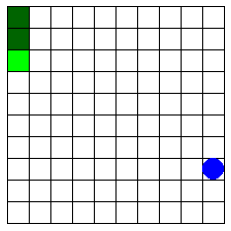

In [19]:
# Agent1 will move down, Agent2 moves up.
obs, rewards, dones, infos = env.step(action={"agent1": 2, "agent2": 0})

env.render()

print("Agent1's x/y position={}".format(env.agent1_pos))
print("Agent2's x/y position={}".format(env.agent2_pos))
print("Env timesteps={}".format(env.timesteps))


In [20]:
class DummyTrainer:
    """Dummy Trainer class used in Exercise #1.

    Use its `compute_action` method to get a new action for one of the agents,
    given the agent's observation (a single discrete value encoding the field
    the agent is currently in).
    """

    def compute_action(self, single_agent_obs=None):
        # Returns a random action for a single agent.
        return np.random.randint(4)  # Discrete(4) -> return rand int between 0 and 3 (incl. 3).

dummy_trainer = DummyTrainer()
# Check, whether it's working.
for _ in range(3):
    # Get action for agent1 (providing agent1's and agent2's positions).
    print("action_agent1={}".format(dummy_trainer.compute_action(np.array([0, 99]))))

    # Get action for agent2 (providing agent2's and agent1's positions).
    print("action_agent2={}".format(dummy_trainer.compute_action(np.array([99, 0]))))

    print()

action_agent1=1
action_agent2=0

action_agent1=1
action_agent2=0

action_agent1=0
action_agent2=0



Write your solution code into this cell here:

In [21]:
# !LIVE CODING!

# Leave the following as-is. It'll help us with rendering the env in this very cell's output.
import time
from ipywidgets import Output
from IPython import display
import time

out = Output()
display.display(out)

with out:

    # Solution to Exercise #1:

    # Start coding here inside this `with`-block:
    # 1) Reset the env.
    env.reset()
    
    # 2) Enter an infinite while loop (to step through the episode).
    while True:
        # 3) Calculate both agents' actions individually, using dummy_trainer.compute_action([individual agent's obs])
        a1 = dummy_trainer.compute_action(obs["agent1"])
        a2 = dummy_trainer.compute_action(obs["agent2"])
        # 4) Compile the actions dict from both individual agents' actions.
        actions = {"agent1": a1, "agent2": a2}
        # 5) Send the actions dict to the env's `step()` method to receive: obs, rewards, dones, info dicts
        obs, rewards, done, infos = env.step(actions)
        # 6) We'll do this together: Render the env.
        # Don't write any code here (skip directly to 7).
        out.clear_output(wait=True)
        
        time.sleep(0.08)
        env.render()
        plt.show()

        # 7) Check, whether the episde is done, if yes, break out of the while loop.
        if done["__all__"]:
            break

# 8) Run it! :)

Output()

In [22]:
import numpy as np
import pprint
import ray
ray.init(ignore_reinit_error=True)  # Hear the engine humming? ;)

2022-10-03 12:32:52,436	INFO worker.py:973 -- Calling ray.init() again after it has already been called.


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.9.12', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '10.13.62.8', 'raylet_ip_address': '10.13.62.8', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-10-03_12-24-15_047385_3254446/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-10-03_12-24-15_047385_3254446/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-10-03_12-24-15_047385_3254446', 'metrics_export_port': 61387, 'gcs_address': '10.13.62.8:44367', 'address': '10.13.62.8:44367', 'node_id': '524a421e0c1430906989b0281fc58968fed46f72bc1c7934fcce498b'})

In [24]:
from ray.rllib.agents.ppo import PPOTrainer
config = {
    "env": MultiAgentArena,  # "my_env" <- if we previously have registered the env with `tune.register_env("[name]", lambda config: [returns env object])`.
    "env_config": {
        "config": {
            "width": 10,
            "height": 10,
            "ts": 100,
        },
    },
    "create_env_on_driver": True,
}
rllib_trainer = PPOTrainer(config=config)
rllib_trainer

2022-10-03 12:33:15,225	INFO trainer.py:2332 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-10-03 12:33:15,227	INFO ppo.py:414 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-10-03 12:33:15,228	INFO trainer.py:903 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-10-03 12:33:15,322	WARNING env.py:216 -- Your MultiAgentEnv <MultiAgentArena instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.


PPOTrainer

(RolloutWorker pid=3256193) pygame 2.1.2 (SDL 2.0.16, Python 3.9.12)
(RolloutWorker pid=3256193) Hello from the pygame community. https://www.pygame.org/contribute.html
(RolloutWorker pid=3256192) pygame 2.1.2 (SDL 2.0.16, Python 3.9.12)
(RolloutWorker pid=3256192) Hello from the pygame community. https://www.pygame.org/contribute.html


(RolloutWorker pid=3256192) 2022-10-03 12:33:18,722	WARNING env.py:216 -- Your MultiAgentEnv <MultiAgentArena instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.


In [25]:
results = rllib_trainer.train()
del results["config"]
pprint.pprint(results)

2022-10-03 12:33:20,910	WARNING deprecation.py:46 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


{'agent_timesteps_total': 4000,
 'counters': {'num_agent_steps_sampled': 4000,
              'num_agent_steps_trained': 4000,
              'num_env_steps_sampled': 4000,
              'num_env_steps_trained': 4000},
 'custom_metrics': {},
 'date': '2022-10-03_12-33-25',
 'done': False,
 'episode_len_mean': 100.0,
 'episode_media': {},
 'episode_reward_max': 17.999999999999986,
 'episode_reward_mean': -8.325,
 'episode_reward_min': -39.00000000000006,
 'episodes_this_iter': 20,
 'episodes_total': 20,
 'experiment_id': 'ffe6fc15c88e4abd89cef6931a1455ee',
 'hist_stats': {'episode_lengths': [100,
                                    100,
                                    100,
                                    100,
                                    100,
                                    100,
                                    100,
                                    100,
                                    100,
                                    100,
                              

In [26]:
policies = {
    "policy1": (None, env.observation_space, env.action_space, {}),
    "policy2": (None, env.observation_space, env.action_space, {"lr": 0.0002}),
}
def policy_mapping_fn(agent_id: str):
    assert agent_id in ["agent1", "agent2"], f"ERROR: invalid agent ID {agent_id}!"
    return "policy1" if agent_id == "agent1" else "policy2"
config.update({
    "multiagent": {
        "policies": policies,
        "policy_mapping_fn": policy_mapping_fn,
    },
})

pprint.pprint(config)
print()
print(f"agent1 is now mapped to {policy_mapping_fn('agent1')}")
print(f"agent2 is now mapped to {policy_mapping_fn('agent2')}")

{'create_env_on_driver': True,
 'env': <class '__main__.MultiAgentArena'>,
 'env_config': {'config': {'height': 10, 'ts': 100, 'width': 10}},
 'multiagent': {'policies': {'policy1': (None,
                                         MultiDiscrete([100 100]),
                                         Discrete(4),
                                         {}),
                             'policy2': (None,
                                         MultiDiscrete([100 100]),
                                         Discrete(4),
                                         {'lr': 0.0002})},
                'policy_mapping_fn': <function policy_mapping_fn at 0x7fdd78227670>}}

agent1 is now mapped to policy1
agent2 is now mapped to policy2


In [27]:
# Recreate our Trainer (we cannot just change the config on-the-fly).
rllib_trainer.stop()

# Using our updated (now multiagent!) config dict.
rllib_trainer = PPOTrainer(config=config)
rllib_trainer

PPOTrainer

(RolloutWorker pid=3256325) pygame 2.1.2 (SDL 2.0.16, Python 3.9.12)
(RolloutWorker pid=3256325) Hello from the pygame community. https://www.pygame.org/contribute.html
(RolloutWorker pid=3256326) pygame 2.1.2 (SDL 2.0.16, Python 3.9.12)
(RolloutWorker pid=3256326) Hello from the pygame community. https://www.pygame.org/contribute.html


(RolloutWorker pid=3256325) 2022-10-03 12:33:37,849	WARNING env.py:216 -- Your MultiAgentEnv <MultiAgentArena instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.


Now that we are setup correctly with two policies as per our "multiagent" config, let's call `train()` on the new Trainer several times (what about 10 times?).

In [28]:
# Run `train()` n times. Repeatedly call `train()` now to see rewards increase.
# Move on once you see (agent1 + agent2) episode rewards of 10.0 or more.
for _ in range(10):
    results = rllib_trainer.train()
    print(f"Iteration={rllib_trainer.iteration}: R(\"return\")={results['episode_reward_mean']}")

(RolloutWorker pid=3256325) 2022-10-03 12:33:39,194	WARNING deprecation.py:46 -- DeprecationWarning: `policy_mapping_fn(agent_id)` has been deprecated. Use `policy_mapping_fn(agent_id, episode, worker, **kwargs)` instead. This will raise an error in the future!


Iteration=1: R("return")=-10.664999999999997
Iteration=2: R("return")=-5.516249999999994
Iteration=3: R("return")=-2.7179999999999915
Iteration=4: R("return")=0.31200000000001005
Iteration=5: R("return")=1.6830000000000067
Iteration=6: R("return")=1.5990000000000066
Iteration=7: R("return")=2.3730000000000064
Iteration=8: R("return")=3.4830000000000036
Iteration=9: R("return")=5.714999999999998
Iteration=10: R("return")=7.0199999999999925


In [29]:
# Do another loop, but this time, we will print out each policies' individual rewards.
for _ in range(10):
    results = rllib_trainer.train()
    r1 = results['policy_reward_mean']['policy1']
    r2 = results['policy_reward_mean']['policy2']
    r = r1 + r2
    print(f"Iteration={rllib_trainer.iteration}: R(\"return\")={r} R1={r1} R2={r2}")

Iteration=11: R("return")=11.115000000000009 R1=17.65 R2=-6.534999999999989
Iteration=12: R("return")=13.104000000000012 R1=19.265 R2=-6.160999999999989
Iteration=13: R("return")=13.737000000000013 R1=19.92 R2=-6.182999999999989
Iteration=14: R("return")=14.973000000000013 R1=20.815 R2=-5.841999999999988
Iteration=15: R("return")=16.581000000000014 R1=22.885 R2=-6.303999999999989
Iteration=16: R("return")=18.92100000000001 R1=25.83 R2=-6.908999999999987
Iteration=17: R("return")=20.325000000000014 R1=26.42 R2=-6.094999999999988
Iteration=18: R("return")=21.243000000000013 R1=26.37 R2=-5.126999999999989
Iteration=19: R("return")=21.24900000000001 R1=23.23 R2=-1.9809999999999914
Iteration=20: R("return")=20.550000000000008 R1=20.54 R2=0.010000000000008875


In [30]:
# We use the `Trainer.save()` method to create a checkpoint.
checkpoint_file = rllib_trainer.save()
print(f"Trainer (at iteration {rllib_trainer.iteration} was saved in '{checkpoint_file}'!")

# Here is what a checkpoint directory contains:
print("The checkpoint directory contains the following files:")
import os
os.listdir(os.path.dirname(checkpoint_file))

Trainer (at iteration 20 was saved in '/home/ajit/ray_results/PPOTrainer_MultiAgentArena_2022-10-03_12-33-34w91p_kvc/checkpoint_000020/checkpoint-20'!
The checkpoint directory contains the following files:


['checkpoint-20.tune_metadata', 'checkpoint-20', '.is_checkpoint']

### Restoring and evaluating a Trainer
In the following cell, we'll learn how to restore a saved Trainer from a checkpoint file.

We'll also evaluate a completely new Trainer (should act more or less randomly) vs an already trained one (the one we just restored from the created checkpoint file).

In [31]:
# Pretend, we wanted to pick up training from a previous run:
new_trainer = PPOTrainer(config=config)
# Evaluate the new trainer (this should yield random results).
results = new_trainer.evaluate()
print(f"Evaluating new trainer: R={results['evaluation']['episode_reward_mean']}")

# Restoring the trained state into the `new_trainer` object.
print(f"Before restoring: Trainer is at iteration={new_trainer.iteration}")
new_trainer.restore(checkpoint_file)
print(f"After restoring: Trainer is at iteration={new_trainer.iteration}")

# Evaluate again (this should yield results we saw after having trained our saved agent).
results = new_trainer.evaluate()
print(f"Evaluating restored trainer: R={results['evaluation']['episode_reward_mean']}")

2022-10-03 12:39:05,194	WARNING deprecation.py:46 -- DeprecationWarning: `policy_mapping_fn(agent_id)` has been deprecated. Use `policy_mapping_fn(agent_id, episode, worker, **kwargs)` instead. This will raise an error in the future!


(RolloutWorker pid=3257636) pygame 2.1.2 (SDL 2.0.16, Python 3.9.12)
(RolloutWorker pid=3257636) Hello from the pygame community. https://www.pygame.org/contribute.html
(RolloutWorker pid=3257635) pygame 2.1.2 (SDL 2.0.16, Python 3.9.12)
(RolloutWorker pid=3257635) Hello from the pygame community. https://www.pygame.org/contribute.html


(RolloutWorker pid=3257635) 2022-10-03 12:39:07,348	WARNING env.py:216 -- Your MultiAgentEnv <MultiAgentArena instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.
2022-10-03 12:39:11,304	INFO trainable.py:588 -- Restored on 10.13.62.8 from checkpoint: /home/ajit/ray_results/PPOTrainer_MultiAgentArena_2022-10-03_12-33-34w91p_kvc/checkpoint_000020/checkpoint-20
2022-10-03 12:39:11,306	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 265.8637044429779, '_episodes_total': 800}


Evaluating new trainer: R=-8.054999999999998
Before restoring: Trainer is at iteration=0
After restoring: Trainer is at iteration=20
Evaluating restored trainer: R=21.19499999999993


In [42]:
out = Output()
display.display(out)

with out:
    obs = env.reset()
    while True:
        a1 = new_trainer.compute_action(obs["agent1"], policy_id="policy1")
        a2 = new_trainer.compute_action(obs["agent2"], policy_id="policy2")
        actions = {"agent1": a1, "agent2": a2}
        obs, rewards, dones, _ = env.step(actions)

        out.clear_output(wait=True)
        env.render()
        plt.show()
        time.sleep(0.07)

        if dones["agent1"] is True:
            break

Output()

In [33]:
rllib_trainer.stop()
new_trainer.stop()

(RolloutWorker pid=2976125) E0930 11:32:59.527818979 2976219 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(RolloutWorker pid=2976129) E0930 11:32:59.528018199 2976259 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(RolloutWorker pid=2976127) E0930 11:32:59.527847016 2976240 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


### Moving stuff to the professional level: RLlib in connection w/ Ray Tune

Running any experiments through Ray Tune is the recommended way of doing things with RLlib. If you look at our
<a href="https://github.com/ray-project/ray/tree/master/rllib/examples">examples scripts folder</a>, you will see that almost all of the scripts use Ray Tune to run the particular RLlib workload demonstrated in each script.

<img src="images/rllib_and_tune.png" width=400>

When setting up hyperparameter sweeps for Tune, we'll do this in our already familiar config dict.

So let's take a quick look at our PPO algo's default config to understand, which hyperparameters we may want to play around with:

In [34]:
# Configuration dicts and Ray Tune.
# Where are the default configuration dicts stored?

# PPO algorithm:
from ray.rllib.agents.ppo import DEFAULT_CONFIG as PPO_DEFAULT_CONFIG
print(f"PPO's default config is:")
pprint.pprint(PPO_DEFAULT_CONFIG)

# DQN algorithm:
#from ray.rllib.agents.dqn import DEFAULT_CONFIG as DQN_DEFAULT_CONFIG
#print(f"DQN's default config is:")
#pprint.pprint(DQN_DEFAULT_CONFIG)

# Common (all algorithms).
#from ray.rllib.agents.trainer import COMMON_CONFIG
#print(f"RLlib Trainer's default config is:")
#pprint.pprint(COMMON_CONFIG)

PPO's default config is:
{'_disable_action_flattening': False,
 '_disable_execution_plan_api': True,
 '_disable_preprocessor_api': False,
 '_fake_gpus': False,
 '_tf_policy_handles_more_than_one_loss': False,
 'action_space': None,
 'actions_in_input_normalized': False,
 'always_attach_evaluation_results': False,
 'batch_mode': 'truncate_episodes',
 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>,
 'clip_actions': False,
 'clip_param': 0.3,
 'clip_rewards': None,
 'collect_metrics_timeout': -1,
 'compress_observations': False,
 'create_env_on_driver': False,
 'custom_eval_function': None,
 'custom_resources_per_worker': {},
 'disable_env_checking': False,
 'eager_max_retraces': 20,
 'eager_tracing': False,
 'entropy_coeff': 0.0,
 'entropy_coeff_schedule': None,
 'env': None,
 'env_config': {},
 'env_task_fn': None,
 'evaluation_config': {},
 'evaluation_duration': 10,
 'evaluation_duration_unit': 'episodes',
 'evaluation_interval': None,
 'evaluation_num_episodes': -

### Let's do a very simple grid-search over two learning rates with tune.run().

In particular, we will try the learning rates 0.00005 and 0.5 using `tune.grid_search([...])`
inside our config dict:

In [ ]:
# Plugging in Ray Tune.
# Note that this is the recommended way to run any experiments with RLlib.
# Reasons:
# - Tune allows you to do hyperparameter tuning in a user-friendly way
#   and at large scale!
# - Tune automatically allocates needed resources for the different
#   hyperparam trials and experiment runs on a cluster.

from ray import tune

# Running stuff with tune, we can re-use the exact
# same config that we used when working with RLlib directly!
tune_config = config.copy()

# Let's add our first hyperparameter search via our config.
# How about we try two different learning rates? Let's say 0.00005 and 0.5 (ouch!).
tune_config["lr"] = tune.grid_search([0.0001, 0.5])  # <- 0.5? again: ouch!
tune_config["train_batch_size"] = tune.grid_search([3000, 4000])

# Now that we will run things "automatically" through tune, we have to
# define one or more stopping criteria.
# Tune will stop the run, once any single one of the criteria is matched (not all of them!).
stop = {
    # Note that the keys used here can be anything present in the above `rllib_trainer.train()` output dict.
    "training_iteration": 5,
    "episode_reward_mean": 20.0,
}

# "PPO" is a registered name that points to RLlib's PPOTrainer.
# See `ray/rllib/agents/registry.py`

# Run a simple experiment until one of the stopping criteria is met.
tune.run(
    "PPO",
    config=tune_config,
    stop=stop,

    # Note that no trainers will be returned from this call here.
    # Tune will create n Trainers internally, run them in parallel and destroy them at the end.
    # However, you can ...
    checkpoint_at_end=True,  # ... create a checkpoint when done.
    checkpoint_freq=10,  # ... create a checkpoint every 10 training iterations.
)

### Why did we use 6 CPUs in the tune run above (3 CPUs per trial)?

PPO - by default - uses 2 "rollout" workers (`num_workers=2`). These are Ray Actors that have their own environment copy(ies) and step through those in parallel. On top of these two "rollout" workers, every Trainer in RLlib always also has a "local" worker, which - in case of PPO - handles the learning updates. This gives us 3 workers (2 rollout + 1 local learner), which require 3 CPUs.

## Exercise No 2

<hr />

Using the `tune_config` that we have built so far, let's run another `tune.run()`, but apply the following changes to our setup this time:
- Setup only 1 learning rate under the "lr" config key. Chose the (seemingly) best value from the run in the previous cell (the one that yielded the highest avg. reward).
- Setup only 1 train batch size under the "train_batch_size" config key. Chose the (seemingly) best value from the run in the previous cell (the one that yielded the highest avg. reward).
- Set `num_workers` to 5, which will allow us to run more environment "rollouts" in parallel and to collect training batches more quickly.
- Set the `num_envs_per_worker` config parameter to 5. This will clone our env on each rollout worker, and thus parallelize action computing forward passes through our neural networks.

Other than that, use the exact same args as in our `tune.run()` call in the previous cell.

**Good luck! :)**


In [36]:
# !LIVE CODING!

# Solution to Exercise #2

# # Run for longer this time (100 iterations) and try to reach 40.0 reward (sum of both agents).
stop = {
    "training_iteration": 10,  # we have the 15min break now to run this many iterations
    "episode_reward_mean": 60.0,  # sum of both agents' rewards. Probably won't reach it, but we should try nevertheless :)
}

# tune_config.update({
# ???
# })

# analysis = tune.run(...)

tune_config["lr"] = 0.0001
tune_config["train_batch_size"] = 3000

tune_config["num_workers"] = 5
tune_config["num_envs_per_worker"] = 5
analysis = tune.run(
    "PPO",
    config=tune_config,
    stop=stop,
    checkpoint_freq=5,
    verbose=1,
)


2022-09-30 11:39:14,190	INFO tune.py:747 -- Total run time: 78.38 seconds (78.05 seconds for the tuning loop).


------------------
## 15 min break :)
------------------


(while the above experiment is running (and hopefully learning))


## How do we extract any checkpoint from a trial of a tune.run?

In [39]:
# The previous tune.run (the one we did before the exercise) returned an Analysis object, from which we can access any checkpoint
# (given we set checkpoint_freq or checkpoint_at_end to reasonable values) like so:
print(analysis)
# Get all trials (we only have one).
trials = analysis.trials
# Assuming, the first trial was the best, we'd like to extract this trial's best checkpoint "":
best_checkpoint = analysis.get_best_checkpoint(trial=trials[0], metric="episode_reward_mean", mode="max")
print(f"Found best checkpoint for trial #2: {best_checkpoint}")



Found best checkpoint for trial #2: /home/ajit/ray_results/PPO/PPO_MultiAgentArena_39d0e_00000_0_2022-09-30_11-37-55/checkpoint_000010/checkpoint-10


In [40]:
# Undo the grid-search config, which RLlib doesn't understand.
rllib_config = tune_config.copy()
rllib_config["lr"] = 0.00005
rllib_config["train_batch_size"] = 4000

# Restore a RLlib Trainer from the checkpoint.
new_trainer = PPOTrainer(config=rllib_config)
new_trainer.restore(best_checkpoint)
new_trainer

2022-09-30 11:39:40,221	WARNING ppo.py:386 -- `train_batch_size` (4000) cannot be achieved with your other settings (num_workers=5 num_envs_per_worker=5 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 160.
2022-09-30 11:39:41,688	INFO trainable.py:588 -- Restored on 10.13.62.8 from checkpoint: /home/ajit/ray_results/PPO/PPO_MultiAgentArena_39d0e_00000_0_2022-09-30_11-37-55/checkpoint_000010/checkpoint-10
2022-09-30 11:39:41,691	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 71.87987494468689, '_episodes_total': 300}


PPOTrainer

In [42]:
out = Output()
display.display(out)

with out:
    obs = env.reset()
    while True:
        a1 = new_trainer.compute_action(obs["agent1"], policy_id="policy1")
        a2 = new_trainer.compute_action(obs["agent2"], policy_id="policy2")
        actions = {"agent1": a1, "agent2": a2}
        obs, rewards, dones, _ = env.step(actions)

        out.clear_output(wait=True)
        env.render()
        plt.show()
        time.sleep(0.07)

        if dones["agent1"] is True:
            break


Output()

## Let's talk about customization options

### Deep Dive: How do we customize RLlib's RL loop?

RLlib offers a callbacks API that allows you to add custom behavior to
all major events during the environment sampling- and learning process.

**Our problem:** So far, we can only see standard stats, such as rewards, episode lengths, etc..
This does not give us enough insights sometimes into important questions, such as: How many times
have both agents collided? or How many times has agent1 discovered a new field?

In the following cell, we will create custom callback "hooks" that will allow us to
add these stats to the returned metrics dict, and which will therefore be displayed in tensorboard!

For that we will override RLlib's DefaultCallbacks class and implement the
`on_episode_start`, `on_episode_step`, and `on_episode_end` methods therein:


In [ ]:
# Override the DefaultCallbacks with your own and implement any methods (hooks)
# that you need.
from ray.rllib.agents.callbacks import DefaultCallbacks
from ray.rllib.evaluation.episode import MultiAgentEpisode


class MyCallbacks(DefaultCallbacks):
    def on_episode_start(self,
                         *,
                         worker,
                         base_env,
                         policies,
                         episode: MultiAgentEpisode,
                         env_index,
                         **kwargs):
        # We will use the `MultiAgentEpisode` object being passed into
        # all episode-related callbacks. It comes with a user_data property (dict),
        # which we can write arbitrary data into.

        # At the end of an episode, we'll transfer that data into the `hist_data`, and `custom_metrics`
        # properties to make sure our custom data is displayed in TensorBoard.

        # The episode is starting:
        # Set per-episode object to capture, which states (observations)
        # have been visited by agent1.
        episode.user_data["new_fields_discovered"] = 0
        # Set per-episode agent2-blocks counter (how many times has agent2 blocked agent1?).
        episode.user_data["num_collisions"] = 0

    def on_episode_step(self,
                        *,
                        worker,
                        base_env,
                        episode: MultiAgentEpisode,
                        env_index,
                        **kwargs):
        # Get both rewards.
        ag1_r = episode.prev_reward_for("agent1")
        ag2_r = episode.prev_reward_for("agent2")

        # Agent1 discovered a new field.
        if ag1_r == 1.0:
            episode.user_data["new_fields_discovered"] += 1
        # Collision.
        elif ag2_r == 1.0:
            episode.user_data["num_collisions"] += 1

    def on_episode_end(self,
                       *,
                       worker,
                       base_env,
                       policies,
                       episode: MultiAgentEpisode,
                       env_index,
                       **kwargs):
        # Episode is done:
        # Write scalar values (sum over rewards) to `custom_metrics` and
        # time-series data (rewards per time step) to `hist_data`.
        # Both will be visible then in TensorBoard.
        episode.custom_metrics["new_fields_discovered"] = episode.user_data["new_fields_discovered"]
        episode.custom_metrics["num_collisions"] = episode.user_data["num_collisions"]


In [ ]:
# Setting up our config to point to our new custom callbacks class:
config = {
    "env": MultiAgentArena,
    "callbacks": MyCallbacks,  # by default, this would point to `rllib.agents.callbacks.DefaultCallbacks`, which does nothing.
    "num_workers": 5,  # we know now: this speeds up things!
}

tune.run(
    "PPO",
    config=config,
    stop={"training_iteration": 20},
    checkpoint_at_end=True,
    # If you'd like to restore the tune run from an existing checkpoint file, you can do the following:
    #restore="/Users/sven/ray_results/PPO/PPO_MultiAgentArena_fd451_00000_0_2021-05-25_15-13-26/checkpoint_000010/checkpoint-10",
)

### Let's check tensorboard for the new custom metrics!

1. Head over to the Anyscale project view and click on the "TensorBoard" butten:

<img src="images/tensorboard_button.png" width=1000>

Alternatively - if you ran this locally on your own machine:

1. Head over to ~/ray_results/PPO/PPO_MultiAgentArena_[some key]_00000_0_[date]_[time]/
1. In that directory, you should see a `event.out....` file.
1. Run `tensorboard --logdir .` and head to https://localhost:6006

<img src="images/tensorboard.png" width=800>


### Deep Dive: Writing custom Models in tf or torch.

In [ ]:
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.utils.framework import try_import_tf, try_import_torch

tf1, tf, tf_version = try_import_tf()
torch, nn = try_import_torch()


# Custom Neural Network Models.
class MyKerasModel(TFModelV2):
    """Custom model for policy gradient algorithms."""

    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name):
        """Build a simple [16, 16]-MLP (+ value branch)."""
        super(MyKerasModel, self).__init__(obs_space, action_space,
                                           num_outputs, model_config, name)
        
        # Keras Input layer.
        self.inputs = tf.keras.layers.Input(
            shape=obs_space.shape, name="observations")

        # Hidden layer (shared by action logits outputs and value output).
        layer_1 = tf.keras.layers.Dense(
            16,
            name="layer1",
            activation=tf.nn.relu)(self.inputs)
        
        # Action logits output.
        logits = tf.keras.layers.Dense(
            num_outputs,
            name="out",
            activation=None)(layer_1)

        # "Value"-branch (single node output).
        # Used by several RLlib algorithms (e.g. PPO) to calculate an observation's value.
        value_out = tf.keras.layers.Dense(
            1,
            name="value",
            activation=None)(layer_1)

        # The actual Keras model:
        self.base_model = tf.keras.Model(self.inputs,
                                         [logits, value_out])

    def forward(self, input_dict, state, seq_lens):
        """Custom-define your forard pass logic here."""
        # Pass inputs through our 2 layers and calculate the "value"
        # of the observation and store it for when `value_function` is called.
        logits, self.cur_value = self.base_model(input_dict["obs"])
        return logits, state

    def value_function(self):
        """Implement the value branch forward pass logic here:
        
        We will just return the already calculated `self.cur_value`.
        """
        assert self.cur_value is not None, "Must call `forward()` first!"
        return tf.reshape(self.cur_value, [-1])


class MyTorchModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name):
        """Build a simple [16, 16]-MLP (+ value branch)."""
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs,
                              model_config, name)
        nn.Module.__init__(self)

        self.device = torch.device("cuda"
                                   if torch.cuda.is_available() else "cpu")

        # Hidden layer (shared by action logits outputs and value output).
        self.layer_1 = nn.Linear(obs_space.shape[0], 16).to(self.device)

        # Action logits output.
        self.layer_out = nn.Linear(16, num_outputs).to(self.device)

        # "Value"-branch (single node output).
        # Used by several RLlib algorithms (e.g. PPO) to calculate an observation's value.
        self.value_branch = nn.Linear(16, 1).to(self.device)
        self.cur_value = None

    def forward(self, input_dict, state, seq_lens):
        """Custom-define your forard pass logic here."""
        # Pass inputs through our 2 layers.
        layer_1_out = self.layer_1(input_dict["obs"])
        logits = self.layer_out(layer_1_out)

        # Calculate the "value" of the observation and store it for
        # when `value_function` is called.
        self.cur_value = self.value_branch(layer_1_out).squeeze(1)

        return logits, state

    def value_function(self):
        """Implement the value branch forward pass logic here:
        
        We will just return the already calculated `self.cur_value`.
        """
        assert self.cur_value is not None, "Must call `forward()` first!"
        return self.cur_value


In [ ]:
# Do a quick test on the custom model classes.
test_model_tf = MyKerasModel(
    obs_space=gym.spaces.Box(-1.0, 1.0, (2, )),
    action_space=None,
    num_outputs=2,
    model_config={},
    name="MyModel",
)

print("TF-output={}".format(test_model_tf({"obs": np.array([[0.5, 0.5]])})))

# For PyTorch, you can do:
#test_model_torch = MyTorchModel(
#    obs_space=gym.spaces.Box(-1.0, 1.0, (2, )),
#    action_space=None,
#    num_outputs=2,
#    model_config={},
#    name="MyModel",
#)
#print("Torch-output={}".format(test_model_torch({"obs": torch.from_numpy(np.array([[0.5, 0.5]], dtype=np.float32))})))


In [ ]:
# Set up our custom model and re-run the experiment.
config.update({
    "model": {
        "custom_model": MyKerasModel,  # for torch users: "custom_model": MyTorchModel
        "custom_model_config": {
            #"layers": [128, 128],
        },
    },
})

tune.run(
    "PPO",
    config=config,  # for torch users: config=dict(config, **{"framework": "torch"}),
    stop={
        "training_iteration": 5,
    },
)


### Deep Dive: A closer look at RLlib's components
#### (Depending on time left and amount of questions having been accumulated :)

We already took a quick look inside an RLlib Trainer object and extracted its Policy(ies) and the Policy's model (neural network). Here is a much more detailed overview of what's inside a Trainer object.

At the core is the so-called `WorkerSet` sitting under `Trainer.workers`. A WorkerSet is a group of `RolloutWorker` (`rllib.evaluation.rollout_worker.py`) objects that always consists of a "local worker" (`Trainer.workers.local_worker()`) and n "remote workers" (`Trainer.workers.remote_workers()`).



<img src="images/rllib_structure.png" width=1000>

### Scaling RLlib

Scaling RLlib works by parallelizing the "jobs" that the remote `RolloutWorkers` do. In a vanilla RL algorithm, like PPO, DQN, and many others, the `@ray.remote` labeled RolloutWorkers in the figure above are responsible for interacting with one or more environments and thereby collecting experiences. Observations are produced by the environment, actions are then computed by the Policy(ies) copy located on the remote worker and sent to the environment in order to produce yet another observation. This cycle is repeated endlessly and only sometimes interrupted to send experience batches ("train batches") of a certain size to the "local worker". There these batches are used to call `Policy.learn_on_batch()`, which performs a loss calculation, followed by a model weights update, and a subsequent weights broadcast back to all the remote workers.



## Time for Q&A

...

## Thank you for listening and participating!

### Here are a couple of links that you may find useful.

- The <a href="https://github.com/sven1977/rllib_tutorials.git">github repo of this tutorial</a>.
- <a href="https://docs.ray.io/en/master/rllib.html">RLlib's documentation main page</a>.
- <a href="http://discuss.ray.io">Our discourse forum</a> to ask questions on Ray and its libraries.
- Our <a href="https://forms.gle/9TSdDYUgxYs8SA9e8">Slack channel</a> for interacting with other Ray RLlib users.
- The <a href="https://github.com/ray-project/ray/blob/master/rllib/examples/">RLlib examples scripts folder</a> with tons of examples on how to do different stuff with RLlib.
- A <a href="https://medium.com/distributed-computing-with-ray/reinforcement-learning-with-rllib-in-the-unity-game-engine-1a98080a7c0d">blog post on training with RLlib inside a Unity3D environment</a>.
